# # Brain Tumor Classification


# ## Clone the Github Repo to access the Dataset


# ## Import necessary Libraries 


In [1]:
import os
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import torch

if torch.cuda.is_available():
    print("Cuda is here!")
else:
    print("Cuda is not here :( ")


2024-08-02 11:16:24.656930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 11:16:24.677736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 11:16:24.684084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 11:16:24.699787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 11:16:25.713071: W tensorflow/compiler/tf2

Cuda is here!



# ## Data Visualization


In [2]:
files_path_dict = {}

# Hope you don't be imprisoned by legacy Python code :)
from pathlib import Path

# `cwd`: current directory is straightforward
cwd = Path.cwd()

train_dir = str(cwd) + "/data/Training"
test_dir = str(cwd) + "/data/Testing"

data_training = {
    'glioma_tumor': [],
    'meningioma_tumor': [],
    'no_tumor': [],
    'pituitary_tumor': []
}
for i in data_training.keys():
    for j in os.listdir(train_dir + "/" + i):
        data_training[i].append(f"{train_dir}/{i}/{j}")

data_testing = {
    'glioma_tumor': [],
    'meningioma_tumor': [],
    'no_tumor': [],
    'pituitary_tumor': []
}
for i in data_testing.keys():
    for j in os.listdir(test_dir + "/" + i):
        data_testing[i].append(f"{test_dir}/{i}/{j}")

len_train = {}
for i in data_training.keys():
    len_train[i] = len(data_training[i])
len_testing = {}
for i in data_testing.keys():
    len_testing[i] = len(data_testing[i])

print({"training": len_train, "testing": len_testing})


{'training': {'glioma_tumor': 8239, 'meningioma_tumor': 4621, 'no_tumor': 4621, 'pituitary_tumor': 4219}, 'testing': {'glioma_tumor': 2269, 'meningioma_tumor': 2250, 'no_tumor': 2340, 'pituitary_tumor': 2311}}


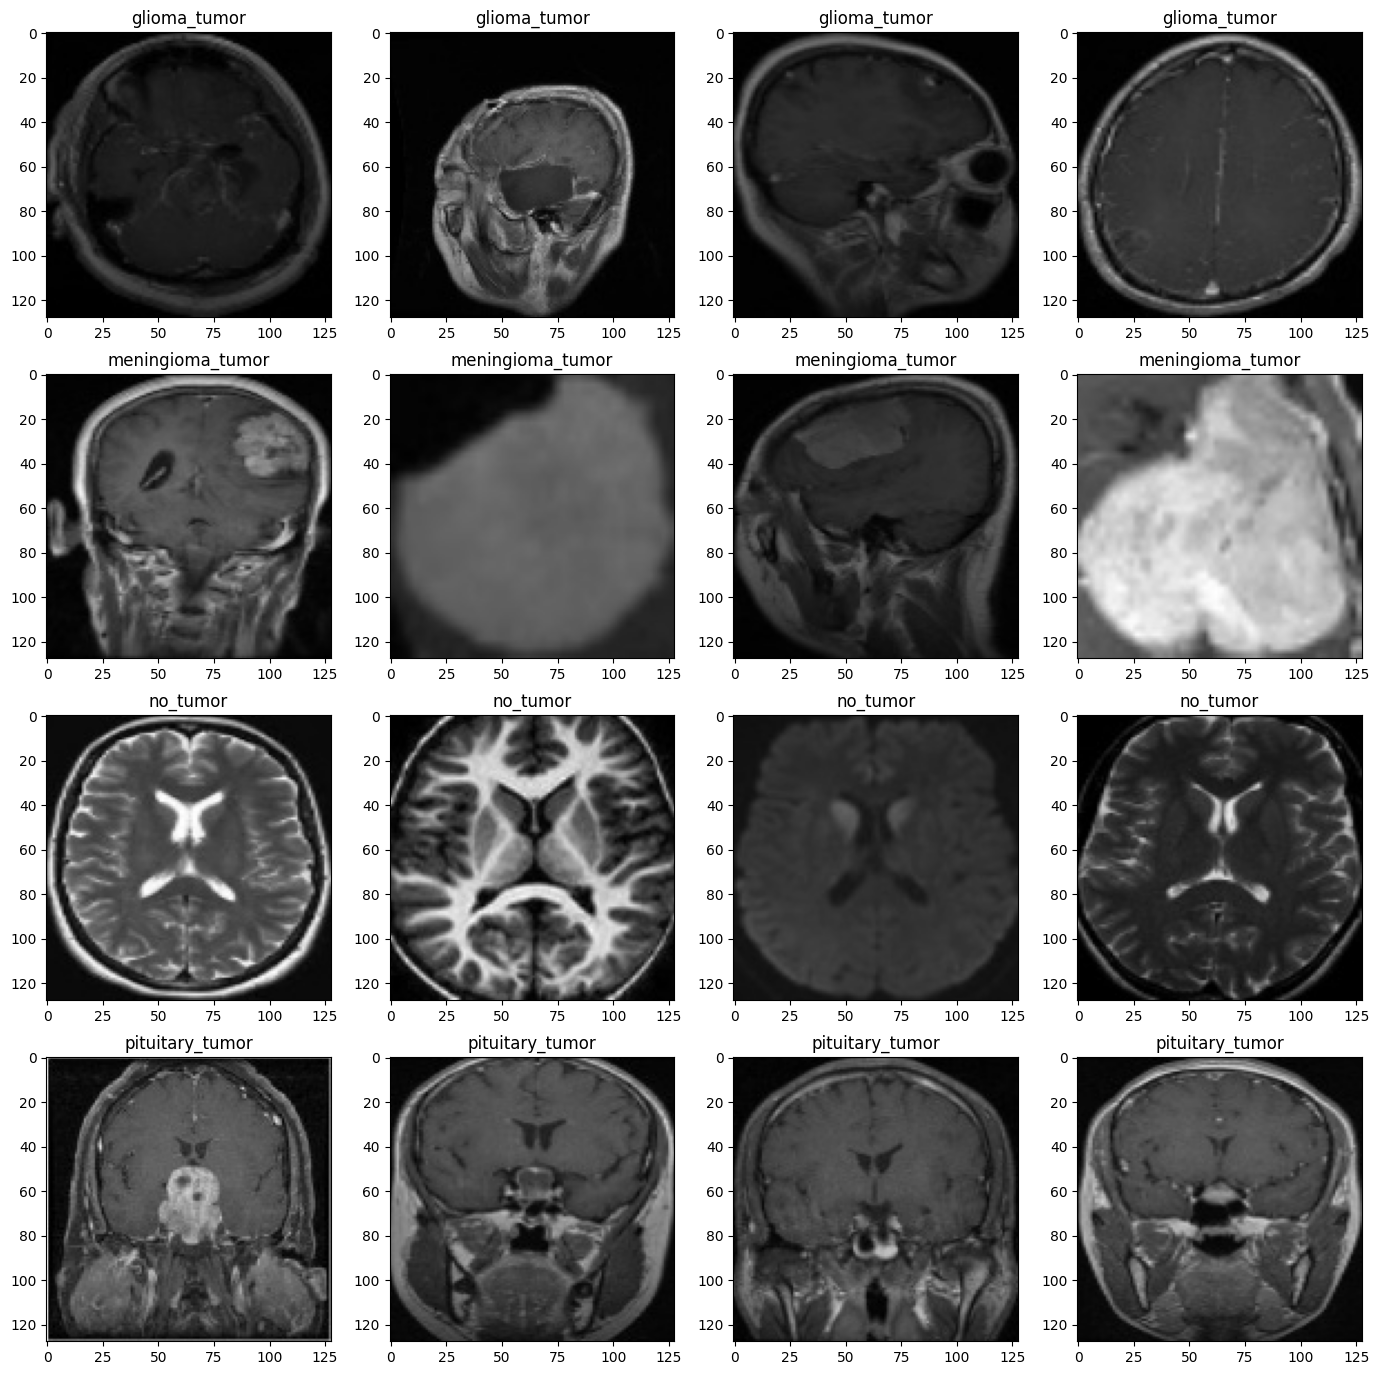

In [3]:
plt.figure(figsize=(17, 17))
index = 0
for c in data_training.keys():
    random.shuffle(data_training[c])
    path_list = data_training[c][:5]

    for i in range(1, 5):
        index += 1
        plt.subplot(4, 4, index)
        plt.imshow(load_img(path_list[i]))
        plt.title(c)


# ## Data Augmentation


In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import functional as F

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0, 0.2)),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Split the training data into training and validation sets
num_train = len(train_dataset)
split = int(0.8 * num_train)  # 80% training, 20% validation
train_size = split
valid_size = num_train - split

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
"train: ", len(train_dataset), "Valid: ", len(valid_dataset), "test: ", len(test_dataset)

('train: ', 17360, 'Valid: ', 4340, 'test: ', 9170)

# ## Model Architect


# ## Compile Model


In [5]:
import torch
import torch.nn as nn
import torchvision

# Instancujte model
model = torchvision.models.efficientnet_b1(progress=True)

if torch.cuda.is_available():
    model.cuda()


# Vytiskněte souhrn modelu
def print_model_summary(model, input_size=(3, 128, 128)):
    from torchsummary import summary
    summary(model, input_size=input_size)


print_model_summary(model)

# print_model_summary(model)

import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()


/home/semillerolun/miniconda3/envs/kan/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

# ## Model Training and Model Evaluation


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop_counter = 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_wts = model.state_dict()
        elif val_loss < self.best_score:
            self.best_score = val_loss
            self.best_model_wts = model.state_dict()
            self.early_stop_counter = 0
        else:
            self.early_stop_counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.early_stop_counter} out of {self.patience}')
            if self.early_stop_counter >= self.patience:
                if self.verbose:
                    print('Early stopping')
                model.load_state_dict(self.best_model_wts)
                return True
        return False


from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, verbose=True)

import torch

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)




/home/semillerolun/miniconda3/envs/kan/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
%%time

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np


accuracy_training = []
accuracy_testing = []
loss_validation = []
loss_training = []

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_acc = 0

    # Training loop with progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:

            if torch.cuda.is_available():
                inputs = inputs.to(torch.device('cuda'))
                labels = labels.to(torch.device('cuda'))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=running_loss / (total + 1e-8), accuracy=correct / total)
            pbar.update()

            # logging 
            accuracy_training.append(correct / total)
            loss_training.append(running_loss / (total + 1e-8))


    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

    accuracy_training.append(epoch_acc)
    loss_training.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Validation loop with progress bar
    with tqdm(total=len(valid_loader), desc='Validation', unit='batch') as pbar:
        with torch.no_grad():
            for inputs, labels in valid_loader:

                if torch.cuda.is_available():
                    inputs = inputs.to(torch.device('cuda'))
                    labels = labels.to(torch.device('cuda'))

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update progress bar
                pbar.set_postfix(val_loss=val_loss / (val_total + 1e-8), val_accuracy=val_correct / val_total)
                pbar.update()
                
                loss_validation.append(val_loss)
                accuracy_testing.append(val_acc)




    val_loss = val_loss / len(valid_dataset)
    val_acc = val_correct / val_total
    print(f'Validation Loss: {val_loss:.4f} - Accuracy: {val_acc:.4f}')



    # Step the scheduler
    scheduler.step(val_acc)

    # Check early stopping
    if early_stopping(val_loss, model):
        num_epochs = epoch
        break

Epoch 1/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.53batch/s, accuracy=0.557, loss=1.14]


Epoch 1/15 - Loss: 1.1424 - Accuracy: 0.5572


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.87batch/s, val_accuracy=0.685, val_loss=0.787]


Validation Loss: 0.7873 - Accuracy: 0.6853


Epoch 2/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.51batch/s, accuracy=0.777, loss=0.593]


Epoch 2/15 - Loss: 0.5928 - Accuracy: 0.7771


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.07batch/s, val_accuracy=0.844, val_loss=0.414]


Validation Loss: 0.4138 - Accuracy: 0.8442


Epoch 3/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.53batch/s, accuracy=0.857, loss=0.391]


Epoch 3/15 - Loss: 0.3914 - Accuracy: 0.8567


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.07batch/s, val_accuracy=0.889, val_loss=0.309]


Validation Loss: 0.3093 - Accuracy: 0.8887


Epoch 4/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.52batch/s, accuracy=0.895, loss=0.297]


Epoch 4/15 - Loss: 0.2968 - Accuracy: 0.8952


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.13batch/s, val_accuracy=0.917, val_loss=0.23]


Validation Loss: 0.2299 - Accuracy: 0.9168


Epoch 5/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:33<00:00,  3.53batch/s, accuracy=0.922, loss=0.226]


Epoch 5/15 - Loss: 0.2264 - Accuracy: 0.9221


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.61batch/s, val_accuracy=0.95, val_loss=0.145]


Validation Loss: 0.1448 - Accuracy: 0.9505


Epoch 6/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:33<00:00,  3.53batch/s, accuracy=0.932, loss=0.196]


Epoch 6/15 - Loss: 0.1958 - Accuracy: 0.9320


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.22batch/s, val_accuracy=0.944, val_loss=0.157]


Validation Loss: 0.1569 - Accuracy: 0.9445
EarlyStopping counter: 1 out of 5


Epoch 7/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.52batch/s, accuracy=0.949, loss=0.156]


Epoch 7/15 - Loss: 0.1557 - Accuracy: 0.9487


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.21batch/s, val_accuracy=0.952, val_loss=0.142]


Validation Loss: 0.1415 - Accuracy: 0.9518


Epoch 8/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:33<00:00,  3.53batch/s, accuracy=0.953, loss=0.142]


Epoch 8/15 - Loss: 0.1419 - Accuracy: 0.9529


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.79batch/s, val_accuracy=0.967, val_loss=0.0998]


Validation Loss: 0.0998 - Accuracy: 0.9666


Epoch 9/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:35<00:00,  3.49batch/s, accuracy=0.959, loss=0.12]


Epoch 9/15 - Loss: 0.1202 - Accuracy: 0.9589


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.91batch/s, val_accuracy=0.963, val_loss=0.115]


Validation Loss: 0.1153 - Accuracy: 0.9634
EarlyStopping counter: 1 out of 5


Epoch 10/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:33<00:00,  3.53batch/s, accuracy=0.963, loss=0.11]


Epoch 10/15 - Loss: 0.1104 - Accuracy: 0.9633


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.88batch/s, val_accuracy=0.971, val_loss=0.082]


Validation Loss: 0.0820 - Accuracy: 0.9712


Epoch 11/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:35<00:00,  3.49batch/s, accuracy=0.967, loss=0.0994]


Epoch 11/15 - Loss: 0.0994 - Accuracy: 0.9666


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.15batch/s, val_accuracy=0.965, val_loss=0.107]


Validation Loss: 0.1069 - Accuracy: 0.9652
EarlyStopping counter: 1 out of 5


Epoch 12/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:34<00:00,  3.52batch/s, accuracy=0.97, loss=0.0921]


Epoch 12/15 - Loss: 0.0921 - Accuracy: 0.9699


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 11.15batch/s, val_accuracy=0.975, val_loss=0.0768]


Validation Loss: 0.0768 - Accuracy: 0.9753


Epoch 13/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:31<00:00,  3.58batch/s, accuracy=0.974, loss=0.0791]


Epoch 13/15 - Loss: 0.0791 - Accuracy: 0.9738


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:11<00:00, 11.44batch/s, val_accuracy=0.973, val_loss=0.0834]


Validation Loss: 0.0834 - Accuracy: 0.9726
EarlyStopping counter: 1 out of 5


Epoch 14/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:31<00:00,  3.59batch/s, accuracy=0.974, loss=0.0783]


Epoch 14/15 - Loss: 0.0783 - Accuracy: 0.9740


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.94batch/s, val_accuracy=0.984, val_loss=0.0567]


Validation Loss: 0.0567 - Accuracy: 0.9836


Epoch 15/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 543/543 [02:33<00:00,  3.53batch/s, accuracy=0.978, loss=0.0678]


Epoch 15/15 - Loss: 0.0678 - Accuracy: 0.9781


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.73batch/s, val_accuracy=0.981, val_loss=0.0649]

Validation Loss: 0.0649 - Accuracy: 0.9806
EarlyStopping counter: 1 out of 5
CPU times: user 6h 35min 40s, sys: 28min 26s, total: 7h 4min 7s
Wall time: 41min 34s


# Model Evaluation


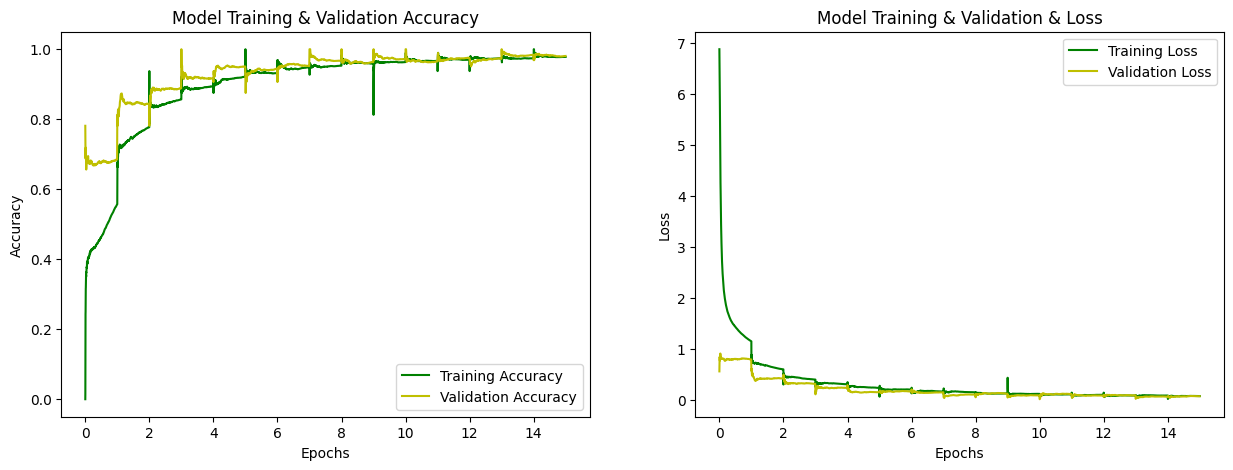

In [17]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

epochs = np.arange(0, num_epochs, num_epochs / len(accuracy_training))

ax[0].plot(epochs, accuracy_training, 'g', label='Training Accuracy')

epochs = np.arange(0, num_epochs, num_epochs / len(accuracy_testing))

ax[0].plot(epochs, accuracy_testing, 'y-', label='Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

epochs = np.arange(0, num_epochs, num_epochs / len(loss_training))

ax[1].plot(epochs, loss_training, 'g', label='Training Loss')

epochs = np.arange(0, num_epochs, num_epochs / len(loss_validation))

ax[1].plot(epochs, loss_validation, 'y-', label='Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
 
plt.show()


In [ ]:
from common import update_json_with_key

update_json_with_key('data.json', model_name, num_epochs, accuracy_training, accuracy_testing, loss_training,
                     loss_validation)
